In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils.ZScoreScaler import ZScoreScaler
from utils.LinearRegressionModel import LinearRegressionModel

In [7]:
df = pd.read_csv('./data/data.csv')
df

,km,price
0,240000,3650
1,139800,3800
2,150500,4400
3,185530,4450
4,176000,5250
5,114800,5350
6,166800,5800
7,89000,5990
8,144500,5999
9,84000,6200


In [15]:
model = LinearRegressionModel(epoch=1000)

In [10]:
x_label = 'km'
y_label = 'price'

scaler_x = ZScoreScaler()
scaler_y = ZScoreScaler()

scaler_x.fit(df[x_label])
scaler_y.fit(df[y_label])

df[x_label] = scaler_x.transform(df[x_label])
df[y_label] = scaler_y.transform(df[y_label])

model = LinearRegressionModel(epoch=1000)
model.fit(df[x_label], df[y_label])

100%|██████████| 1000/1000 [00:00<00:00, 66677.86it/s]


In [21]:
input_value = 240000

predicted_value = model.predict(scaler_x.transform(input_value))
inverse_transform_output = scaler_y.inverse_transform(predicted_value)

print(f'Predicted: {predicted_value} transform backed to {inverse_transform_output}')

Predicted: 0.0 transform backed to 6331.833333333333


In [22]:
print(f'f(x) = {model.get_slope()}x + {model.get_y_intercept()}')

f(x) = 0x + 0


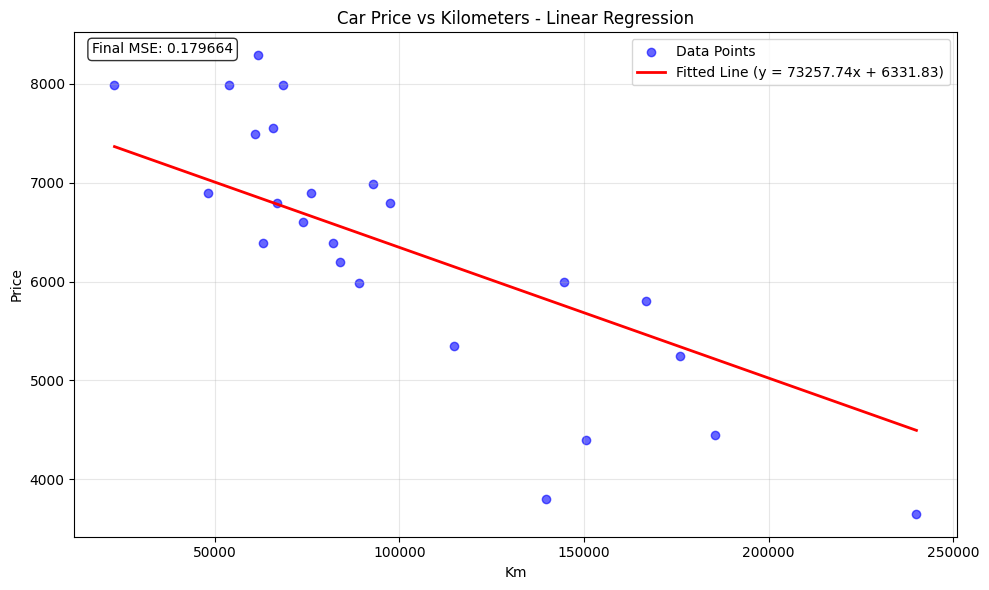

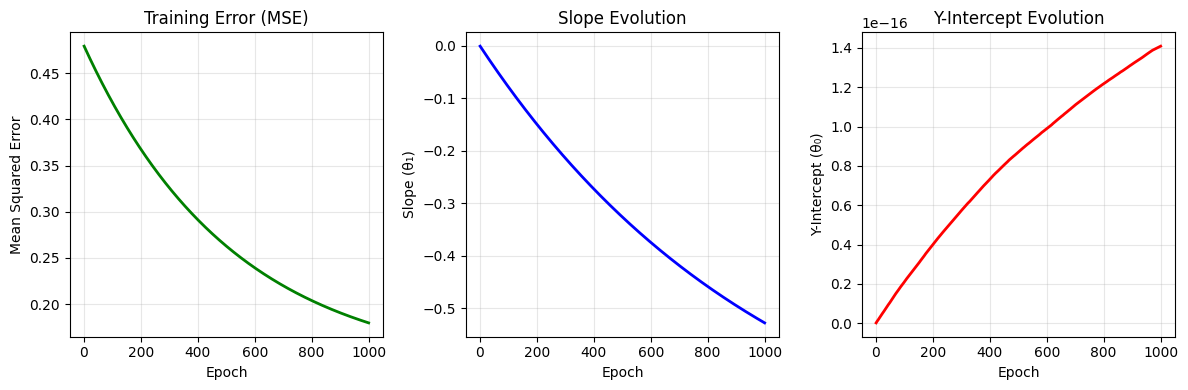

In [ ]:
def plot_linear_regression_results(df, model, scaler_x, scaler_y, x_label, y_label, title="Linear Regression Results", figsize=(10, 6)):
    
    fig, ax = plt.subplots(figsize=figsize)
    
    x_scaled = df[x_label].values
    y_scaled = df[y_label].values
    
    x_original = scaler_x.inverse_transform(x_scaled)
    y_original = scaler_y.inverse_transform(y_scaled)
    
    ax.scatter(x_original, y_original, alpha=0.6, color='blue', label='Data Points')
    
    x_range_scaled = np.linspace(x_scaled.min(), x_scaled.max(), 100)
    y_pred_scaled = model.predict(x_range_scaled)
    
    x_range_original = scaler_x.inverse_transform(x_range_scaled)
    y_pred_original = scaler_y.inverse_transform(y_pred_scaled)
    
    ax.plot(x_range_original, y_pred_original, color='red', linewidth=2, 
            label=f'Fitted Line (y = {scaler_x.inverse_transform(model.get_slope()):.2f}x + {scaler_y.inverse_transform(model.get_y_intercept()):.2f})')
    
    ax.set_xlabel(x_label.title())
    ax.set_ylabel(y_label.title())
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    final_mse = model.error_history[-1] if model.error_history else 0

    ax.text(0.02, 0.98, f'Final MSE: {final_mse:.6f}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    return fig, ax


def plot_training_history(model, figsize=(12, 4)):
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    epochs = range(1, len(model.error_history) + 1)
    
    # Plot error history
    axes[0].plot(epochs, model.error_history, color='green', linewidth=2)
    axes[0].set_title('Training Error (MSE)')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Mean Squared Error')
    axes[0].grid(True, alpha=0.3)
    
    # Plot slope history
    axes[1].plot(epochs, model.slope_history, color='blue', linewidth=2)
    axes[1].set_title('Slope Evolution')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Slope (θ₁)')
    axes[1].grid(True, alpha=0.3)
    
    # Plot y-intercept history
    axes[2].plot(epochs, model.y_intercept_history, color='red', linewidth=2)
    axes[2].set_title('Y-Intercept Evolution')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Y-Intercept (θ₀)')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, axes


# Example usage function
def example_usage():
    """
    Example of how to use the plotting functions with your model.
    """
    # Assuming you have your df, model, scalers, and labels from your training code
    
    # Plot the regression results
    fig1, ax1 = plot_linear_regression_results(
        df, model, scaler_x, scaler_y, x_label, y_label,
        title="Car Price vs Kilometers - Linear Regression"
    )
    
    # Plot the training history
    fig2, axes2 = plot_training_history(model)
    
    # Show the plots
    plt.show()

example_usage()